# Sales Forecasting for Supermarkets

### References:
##### Data Source/Data Dictionary: 
https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales?resource=download
#### Forecasting:
https://cseweb.ucsd.edu/classes/wi15/cse255-a/reports/fa15/004.pdf

https://medium.com/@prashant.nair2050/hands-on-outlier-detection-and-treatment-in-python-using-1-5-iqr-rule-f9ff1961a414

https://it.unt.edu/sites/default/files/categoricalregression_jds_june2010.pdf

Predict sales for Q1'19 of 3 supermarkets in cities across Myanmar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("input/supermarket_sales - Sheet2.csv")
df.head()

,Invoice ID,Branch,City,Customer type,Product line,Quantity,Tax 5%,Total,Date
0,750-67-8428,A,Yangon,Member,Health and beauty,7,26.1415,548.9715,1/5/19
1,226-31-3081,C,Naypyitaw,Normal,Electronic accessories,5,3.8200,80.2200,3/8/19
2,631-41-3108,A,Yangon,Normal,Home and lifestyle,7,16.2155,340.5255,3/3/19
3,123-19-1176,A,Yangon,Member,Health and beauty,8,23.2880,489.0480,1/27/19
4,373-73-7910,A,Yangon,Normal,Sports and travel,7,30.2085,634.3785,2/8/19


# Remove Outliers

First, remove the tax from the total and then use the 1.5 inter-quartile rule to remove outliers.

In [3]:
df['Tax 5%']=df['Tax 5%'].apply(np.ceil)
df['Total']=df['Total'].apply(np.ceil)
df['Total']=df['Total']-df['Tax 5%']

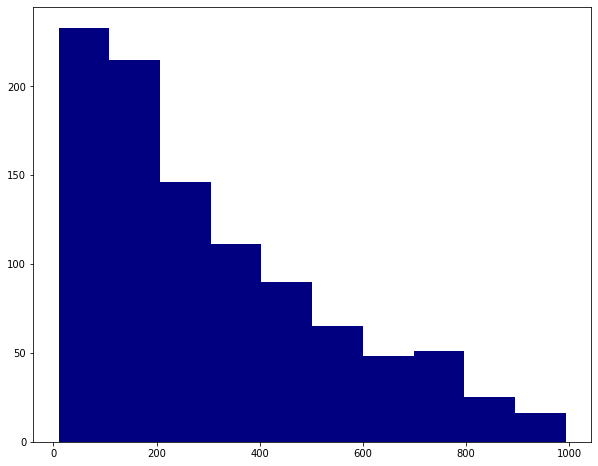

In [4]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
width=0.35

ax.hist(df['Total'],color='navy')

plt.savefig('output/total_histogram.png')

In [5]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3-Q1
    lower_range = Q1-(1.5*IQR)
    upper_range = Q3+(1.5*IQR)
    
    return lower_range,upper_range

lowerbound,upperbound = outlier_treatment(df['Total'])
df=df[(df.Total > lowerbound) | (df.Total < upperbound)]

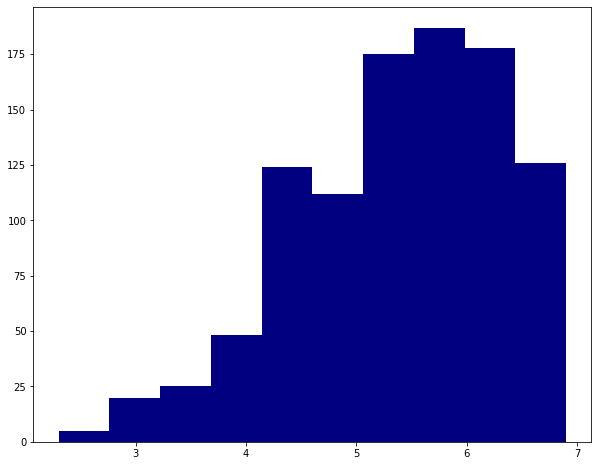

In [6]:
df['Total_log']=np.log(df['Total'])
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
width=0.35

ax.hist(df['Total_log'],color='navy')

plt.savefig('output/log_total_histogram.png')

# Propensity Branch Sells a Product

The 3 branches distribute the same 6 product: Electronics, Fashion, Food, Health, Home and Travel, with each branch driving the sales of a specific product line. Branch A drives sales of Home, while branch B drives the sales of Health products and branch C has the most sales of Food products. The Branch and Product Line may be strong predictors of sales across 3 months. Another consideration, may be the Day of the Week, because some stores may have varied performance on a given day.  

In [7]:
df1=df[['Branch','Product line','Total']]
df_total_sale_branch_prod_line=df1.groupby(['Branch','Product line']).sum().reset_index()
df_prod_line_total=df1.groupby(['Product line']).sum().reset_index()

df2=pd.merge(df_total_sale_branch_prod_line,df_prod_line_total,on='Product line').rename({'Total_x':'Branch_Total','Total_y':'Total'},axis=1)
df2['Ratio_Sales_per_Prod']=round((df2['Branch_Total']/df2['Total']*100),0)
df2=df2[['Branch','Product line','Ratio_Sales_per_Prod']]
df2=pd.pivot_table(df2, values='Ratio_Sales_per_Prod', index='Product line', columns='Branch',aggfunc=np.sum).reset_index()
df2

Branch,Product line,A,B,C
0,Electronic accessories,34.0,31.0,35.0
1,Fashion accessories,30.0,30.0,40.0
2,Food and beverages,31.0,27.0,42.0
3,Health and beauty,26.0,41.0,34.0
4,Home and lifestyle,42.0,33.0,26.0
5,Sports and travel,35.0,36.0,29.0


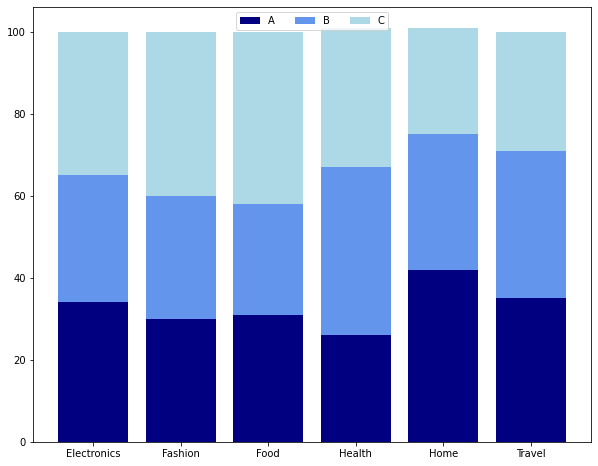

In [8]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
labels=['Electronics','Fashion','Food','Health','Home','Travel']
a_propensity_prod=np.array(df2['A'].astype(int).to_list())
b_propensity_prod=np.array(df2['B'].astype(int).to_list())
c_propensity_prod=np.array(df2['C'].astype(int).to_list())

ax.bar(labels, a_propensity_prod, label='A', color='navy')
ax.bar(labels, b_propensity_prod, label='B',bottom=a_propensity_prod, color='cornflowerblue')
ax.bar(labels, c_propensity_prod, label='C',bottom=a_propensity_prod+b_propensity_prod, color='lightblue')

ax.legend(loc='upper center',ncol=len(labels))
plt.savefig('output/prod_line_per_branch.png')

# Median Sales per Day

All the branches are open 7 days a week, with certain stores generating higher sales on specific days. Both stores A and C generate the least sales on Tuesday, while store A generates the most sales on Saturday and store C performs the best on Sunday. Store B generates the most sales at $300 on Thursday and drops by 33%, to the lowest sales, on Friday. The days of the week of a sale may be a good predictor for sales performance for a given branch.

In [9]:
df3=df[['Branch','Date','Total']]
df3['Date']=pd.to_datetime(df3['Date'])
df3['Day of Week'] = df3['Date'].dt.day_name()
df3=df3[['Branch','Day of Week','Total']]
df3=df3.groupby(['Day of Week','Branch']).median()

df3=pd.pivot_table(df3, values='Total', index='Day of Week', columns='Branch',aggfunc=np.median).reset_index()

def func(df):
    if df['Day of Week'] == 'Sunday':
        return 1
    elif df['Day of Week'] =='Monday':
        return 2
    elif df['Day of Week'] =='Tuesday':
        return 3
    elif df['Day of Week'] =='Wednesday':
        return 4
    elif df['Day of Week'] =='Thursday':
        return 5
    elif df['Day of Week'] =='Friday':
        return 6
    else:
        return 7

df3['Day of Week Order'] = df3.apply(func, axis=1)
df3.sort_values("Day of Week Order",inplace=True)
df3

Branch,Day of Week,A,B,C,Day of Week Order
3,Sunday,261.0,236.0,324.5,1
1,Monday,223.5,231.0,228.0,2
5,Tuesday,167.0,267.0,201.5,3
6,Wednesday,233.0,189.5,214.0,4
4,Thursday,236.0,299.5,205.5,5
0,Friday,221.0,186.0,276.5,6
2,Saturday,282.0,274.0,288.0,7


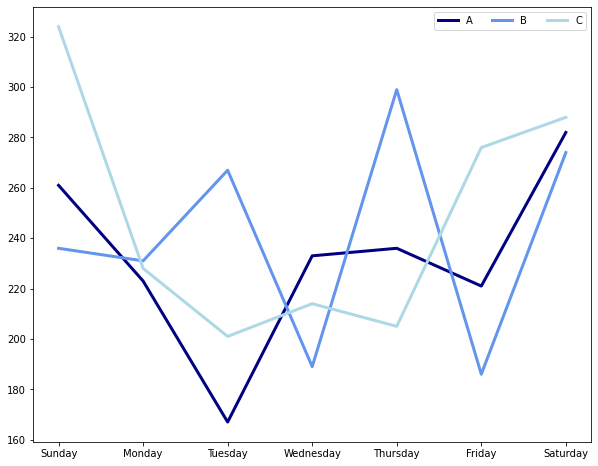

In [10]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
labels=['A','B','C']

x_day_wk=np.array(df3['Day of Week'].astype(str).to_list())
a_sale=np.array(df3['A'].astype(int).to_list())
b_sale=np.array(df3['B'].astype(int).to_list())
c_sale=np.array(df3['C'].astype(int).to_list())

ax.plot(x_day_wk, a_sale, color='navy', linewidth=3)
ax.plot(x_day_wk, b_sale, color='cornflowerblue', linewidth=3)
ax.plot(x_day_wk, c_sale, color='lightblue', linewidth=3)

ax.legend(['A', 'B', 'C'],loc='upper right',ncol=len(labels))

plt.savefig('output/branch_time.png')

# Branches per City
Each branch is in a different city in Myanmar, with:
- Branch A in Yangon. Yangon has a population of 5,244,000
- Branch B in Mandalay. Mandalay has a population of 1,406,000
- Branch C in Naypyitaw. Naypyitaw has a population of 546,000

Yangon has the largest population, so more people may visit the store, resulting in higher sales in Branch A than other branches. The current dataset does not include information about the number of customers who visit the store.

It may be possible that the same customer may have multiple invoices at the same store and at other branches.

In [11]:
df4=df[['City','Branch']]
df4=df4.groupby(['City']).nunique()
df4.drop(columns='City',axis=1,inplace=True)
df4.reset_index(inplace=True)
df4

,City,Branch
0,Mandalay,1
1,Naypyitaw,1
2,Yangon,1


In [12]:
map = folium.Map(location = [21.916,95.956], tiles = "Stamen Terrain", zoom_start = 7)

folium.Marker(
  location=[16.840,96.173],
  popup='Yangon'
).add_to(map)

folium.Marker(
  location=[21.958,96.089],
  popup='Mandalay'
).add_to(map)

folium.Marker(
  location=[19.763,96.078],
  popup='Naypyitaw'
).add_to(map)

map.save("output/branch_map.html")

# Median Sales per Customer Type

Customers can obtain membership at the supermarket chain. In both Branch A and B, members tend to have higher average sales than normal consumers, with Branch C having on par sales for both groups (sales different at p=0.5).

In [13]:
df5=df[['Branch','Customer type','Total']]
df5=df.groupby(['Branch','Customer type']).median()
df5=pd.pivot_table(df5, values='Total', index='Branch', columns='Customer type',aggfunc=np.sum).reset_index()

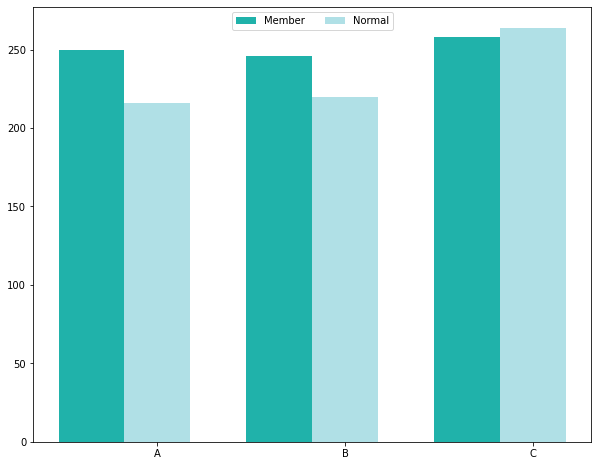

In [14]:
labels_arr=df5['Branch'].to_list()
mem_arr=df5['Member'].to_list()
norm_arr=df5['Normal'].to_list()

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
width=0.35

x = np.arange(len(labels))

rects1 = ax.bar(x - width/2, mem_arr, width, label='Member',tick_label=labels_arr,color='lightseagreen')
rects2 = ax.bar(x + width/2, norm_arr, width, label='Normal',tick_label=labels_arr,color='powderblue')

ax.legend(loc='upper center',ncol=len(labels))

plt.savefig('output/branch_mem_total_sales.png')

In [15]:
df6=df[['Branch','Customer type','Total']]
df6_mem=df6[(df6['Customer type'] == 'Member') & (df6['Branch'] == 'A')]['Total']
df6_norm=df6[(df6['Customer type'] == 'Normal') & (df6['Branch'] == 'A')]['Total']
stats.ttest_ind(df6_mem,df6_norm)

Ttest_indResult(statistic=0.6906380091475369, pvalue=0.4902670482885446)

# Encode Categorical Data for Analysis

In [16]:
df['branchA'] = np.where(df['Branch']=='A', 1, 0)
df['branchB'] = np.where(df['Branch']=='B', 1, 0)
df['custMem'] = np.where(df['Customer type']=='Member', 1, 0)

wk_arr=['Monday','Tuesday','Wednesday','Thursday','Friday']

df['Date']=pd.to_datetime(df['Date'])
df['Day of Week'] = df['Date'].dt.day_name()

df['wk_day'] = np.where(df['Day of Week'].isin(wk_arr), 1, 0)

prod_arr=['Electronic accessories','Sports and travel','Fashion accessories']

com_prod=['Health and beauty','Food and beverages','Electronic accessories']

df['necessity'] = np.where(df['Product line'].isin(com_prod), df['Quantity'], 0)

In [17]:
df7=df[['branchA','branchB','custMem','wk_day','Quantity','Total','Total_log']]
df7.head()

,branchA,branchB,custMem,wk_day,Quantity,Total,Total_log
0,1,0,1,0,7,522.0,6.257668
1,0,0,0,1,5,77.0,4.343805
2,1,0,0,0,7,324.0,5.780744
3,1,0,1,0,8,466.0,6.144186
4,1,0,0,1,7,604.0,6.403574


# Check for multi-collinearity

<AxesSubplot:>

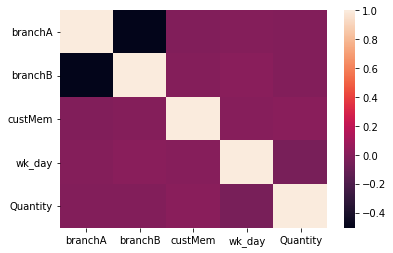

In [18]:
df8=df[['branchA','branchB','custMem','wk_day','Quantity']]
sns.heatmap(df8.corr())

# Linear Regression

In [19]:
X1 = ['branchA','branchB','custMem','wk_day','Quantity']

reg1 = sm.OLS(df7['Total'], df7[X1]).fit()

In [20]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1'
                                        ],
                            info_dict=info_dict
                           )

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

Table 2 - OLS Regressions
                 Model 1 
-------------------------
branchA          -14.65  
                 (11.78) 
branchB          -8.26   
                 (11.91) 
custMem          4.88    
                 (10.00) 
wk_day           -2.19   
                 (9.96)  
Quantity         56.93***
                 (1.42)  
R-squared        0.82    
R-squared Adj.   0.82    
R-squared        0.82    
No. observations 1000    
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


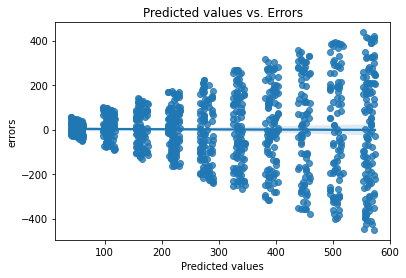

In [21]:
def print_resids(preds, resids):
    ax = sns.regplot(preds, resids);
    ax.set(xlabel = 'Predicted values', ylabel = 'errors', title = 'Predicted values vs. Errors')
    plt.show();
    
print_resids(reg1.predict(df7[X1]), reg1.resid)